In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.tseries.offsets import DateOffset

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
data = pd.read_excel('mnths.xlsx',index_col ='date', parse_dates =True)

In [3]:
data.head()

bikes rented
date                    
2011-01-01         38189
2011-02-01         48215
2011-03-01         64045
2011-04-01         94870
2011-05-01        135821

In [4]:
data.plot(figsize=(15, 6))
plt.show()

In [5]:
#Dicky-Fuller test
result = adfuller(data['bikes rented'])
print(result)

(0.3491580615134362, 0.9794907702783783, 9, 14, {'1%': -4.01203360058309, '5%': -3.1041838775510207, '10%': -2.6909873469387753}, 317.44818873050383)


In [6]:
data2 = data.diff(7).dropna()

In [7]:
result = adfuller(data2['bikes rented'])
print(result)

(-3.794854011542093, 0.002960406190932884, 6, 10, {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487}, 227.37018749005244)


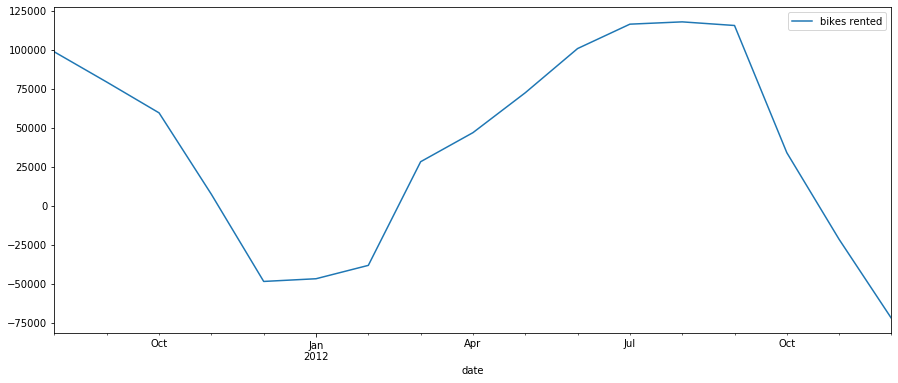

In [8]:
data2.plot(figsize=(15, 6))
plt.show()

## ARIMA & ARMA

#### Auto-Arima

In [9]:
# Checking Seasonal decomposition

decomp = seasonal_decompose(data,freq=12)
decomp.plot()
plt.show()

In [10]:
model_s = pm.auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model_s.summary())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=274.400, BIC=276.825, Fit time=0.301 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=272.361, BIC=273.331, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=275.565, BIC=277.505, Fit time=0.223 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=278.437, BIC=280.377, Fit time=0.074 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=306.663, BIC=307.148, Fit time=0.007 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=274.351, BIC=275.805, Fit time=0.030 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=274.311, BIC=275.766, Fit time=0.034 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=276.260, BIC=278.199, Fit time=0.070 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=273.806, BIC=275.261, Fit time=0.012 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 

In [11]:
#Train Test Split
train = data.loc['2011-01-01':'2012-04-01']
test = data.loc['2012-05-01':]

In [12]:
results = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False, dynamic =False)
fitted = results.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        bikes rented   No. Observations:                   16
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                     nan
Date:                             Fri, 10 Apr 2020   AIC                                nan
Time:                                     17:33:20   BIC                                nan
Sample:                                 01-01-2011   HQIC                               nan
                                      - 04-01-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1      -2.727e+15        nan        nan        nan         nan         nan
sigma2            nan        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

#### Arma

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8))

plot_acf(data2, lags=10, zero=False, ax=ax1)

plot_pacf(data2, lags=10, zero=False, ax=ax2)

plt.show()

In [14]:
for p in range(4):
    for q in range(4):
        try:
            model = SARIMAX(data2, order=(p,0,q), trend='c')
            results = model.fit()
            print(p, q, results.aic, results.bic)
        
        except:
            print(p, q, None, None)

0 0 427.7782520738407 429.4446787619531
0 1 421.82489897135804 424.3245390035267
0 2 414.92647743635223 418.2593308125771
0 3 409.6780186571385 413.8440853774196
1 0 415.9024905983029 418.40213063047156
1 1 413.1402647742851 416.47311815050995
1 2 410.60174018713815 414.76780690741924
1 3 411.5066516179006 416.50593168223793
2 0 403.4226840772826 406.7555374535075
2 1 403.8623187414421 408.0283854617232
2 2 404.1382985298506 409.1375785941879
2 3 402.72440697407274 408.55690038246627
3 0 400.70223805921927 404.86830477950036
3 1 402.1604641161096 407.1597441804469
3 2 401.7206277322361 407.5531211406296
3 3 502.4656014318593 509.13130818430903


In [15]:
arma = SARIMAX(data2, order=(3,0,0), trend ='c')
results = arma.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:           bikes rented   No. Observations:                   17
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -195.351
Date:                Fri, 10 Apr 2020   AIC                            400.702
Time:                        17:33:29   BIC                            404.868
Sample:                    08-01-2011   HQIC                           401.116
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.824e+04   8996.654      2.027      0.043     604.118    3.59e+04
ar.L1          1.0368      0.262      3.960      0.000       0.524       1.550
ar.L2         -0.0244      0.539     -0.045      0.9

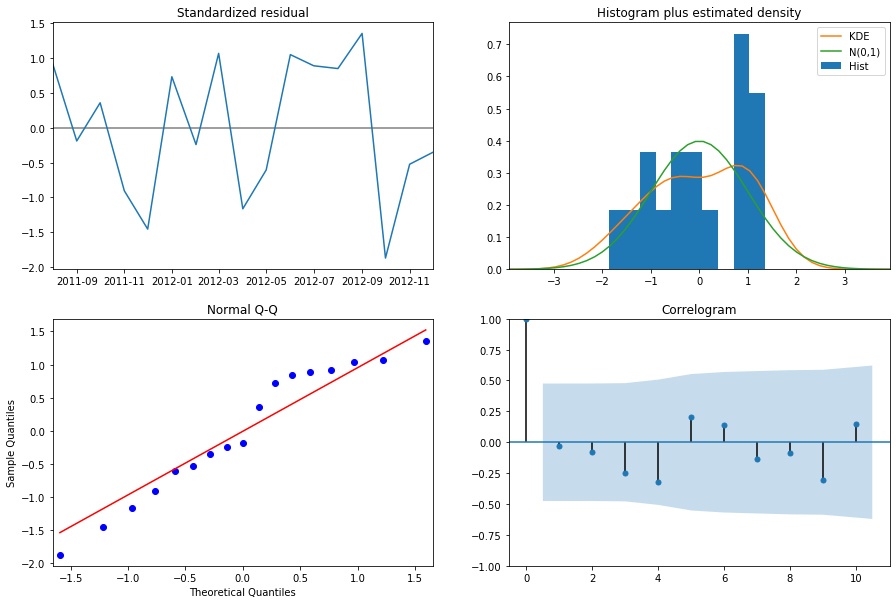

In [16]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

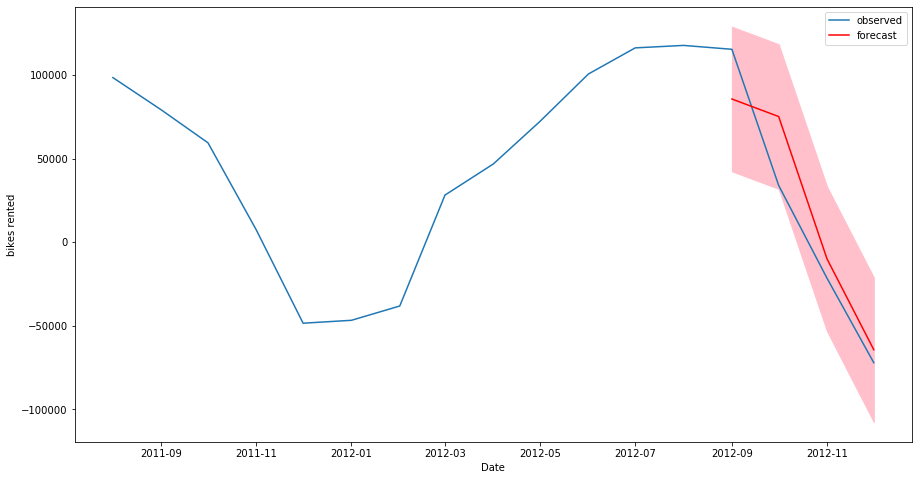

In [17]:
# Sample Prediction

one_step_forecast = results.get_prediction(start=-4)
mean_forecast = one_step_forecast.predicted_mean
confidence_intervals = one_step_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower bikes rented']
upper_limits = confidence_intervals.loc[:, 'upper bikes rented']

plt.figure(figsize=(15, 8))
plt.plot(data2.index, data2, label='observed')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')
plt.xlabel('Date')
plt.ylabel('bikes rented')
plt.legend()
plt.show()

2012-09-01    85681.284461
2012-10-01    44345.178356
2012-11-01     1509.605551
2012-12-01   -25383.569637
Freq: MS, dtype: float64


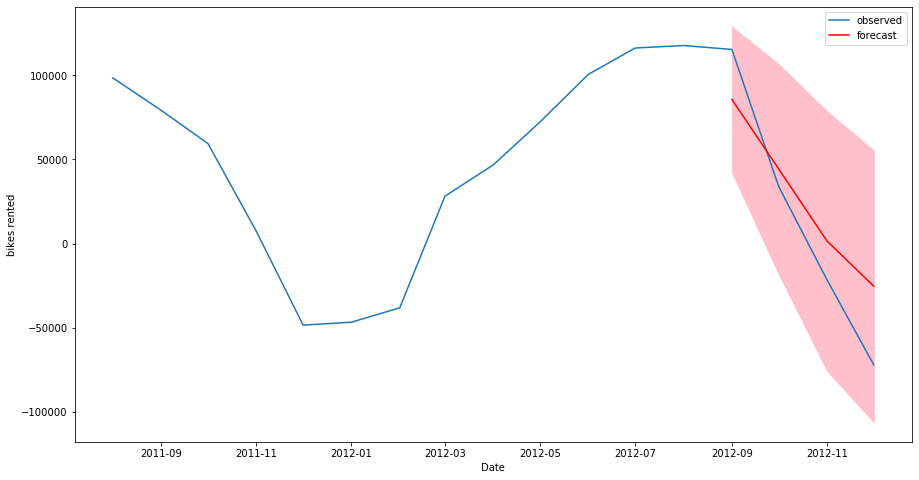

In [18]:
# Dynamic Prediction

one_step_forecast = results.get_prediction(start=-4, dynamic = True)
mean_forecast = one_step_forecast.predicted_mean
print(mean_forecast)
confidence_intervals = one_step_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower bikes rented']
upper_limits = confidence_intervals.loc[:, 'upper bikes rented']

plt.figure(figsize=(15, 8))
plt.plot(data2.index, data2, label='observed')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')
plt.xlabel('Date')
plt.ylabel('bikes rented')
plt.legend()
plt.show()

2013-01-01    -73530.527376
2013-02-01    -45143.946979
2013-03-01     10364.089728
2013-04-01     67933.931438
2013-05-01    111658.472293
2013-06-01    127016.672721
Freq: MS, dtype: float64


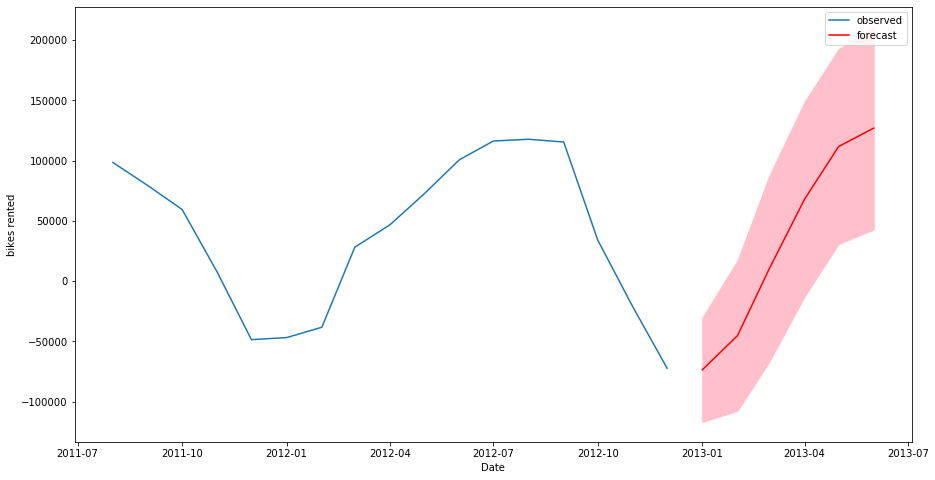

In [19]:
# Future Predictions

forecast = results.get_forecast(steps=6)
arma_value_forecast = forecast.predicted_mean
print(arma_value_forecast)
confidence_intervals = forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower bikes rented']
upper_limits = confidence_intervals.loc[:, 'upper bikes rented']

plt.figure(figsize=(15, 8))
plt.plot(data2.index, data2, label='observed')
plt.plot(arma_value_forecast.index, arma_value_forecast, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')
plt.xlabel('Date')
plt.ylabel('bikes rented')
plt.legend()
plt.show()

## LSTM

In [26]:
dt2 = data2
dt2

bikes rented
date                    
2011-08-01       98502.0
2011-09-01       79203.0
2011-10-01       59466.0
2011-11-01        7297.0
2011-12-01      -48498.0
2012-01-01      -46768.0
2012-02-01      -38204.0
2012-03-01       28184.0
2012-04-01       46806.0
2012-05-01       72354.0
2012-06-01      100663.0
2012-07-01      116284.0
2012-08-01      117759.0
2012-09-01      115436.0
2012-10-01       33966.0
2012-11-01      -21560.0
2012-12-01      -72152.0

In [53]:
train, test = dt2[:-5],dt2[-5:]

In [54]:
scalar =MinMaxScaler()
scalar.fit(train)
train = scalar.transform(train)
test = scalar.transform(test)

In [55]:
train.shape

(12, 1)

In [56]:
test.shape

(5, 1)

In [62]:
n_input = 5
n_features = 1
generator = TimeseriesGenerator(train, train, n_input, batch_size =6)

model = Sequential()
# Adding the input layer and LSTM layer
model.add(LSTM(200, activation= 'relu', input_shape =(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer ='adam', loss='mse')
model.fit_generator(generator, epochs =200)

Epoch 1/200
2/2 [==============================] - 1s 469ms/step - loss: 0.5953
Epoch 2/200
2/2 [==============================] - 0s 48ms/step - loss: 0.5874
Epoch 3/200
2/2 [==============================] - 0s 56ms/step - loss: 0.5350
Epoch 4/200
2/2 [==============================] - 0s 46ms/step - loss: 0.5058
Epoch 5/200
2/2 [==============================] - 0s 51ms/step - loss: 0.4710
Epoch 6/200
2/2 [==============================] - 0s 51ms/step - loss: 0.4401
Epoch 7/200
2/2 [==============================] - 0s 49ms/step - loss: 0.4270
Epoch 8/200
2/2 [==============================] - 0s 53ms/step - loss: 0.3752
Epoch 9/200
2/2 [==============================] - 0s 49ms/step - loss: 0.3439
Epoch 10/200
2/2 [==============================] - 0s 52ms/step - loss: 0.3328
Epoch 11/200
2/2 [==============================] - 0s 53ms/step - loss: 0.2972
Epoch 12/200
2/2 [==============================] - 0s 49ms/step - loss: 0.2603
Epoch 13/200
2/2 [==============================

In [63]:
pred_list =[]
batch = train[-n_input:].reshape(1, n_input, n_features)
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis=1)

In [64]:
dt2_predict= pd.DataFrame(scalar.inverse_transform(pred_list), index= dt2[-n_input:].index, columns =['Predictions'])

In [65]:
dt2_test = pd.concat([dt2, dt2_predict], axis =1)

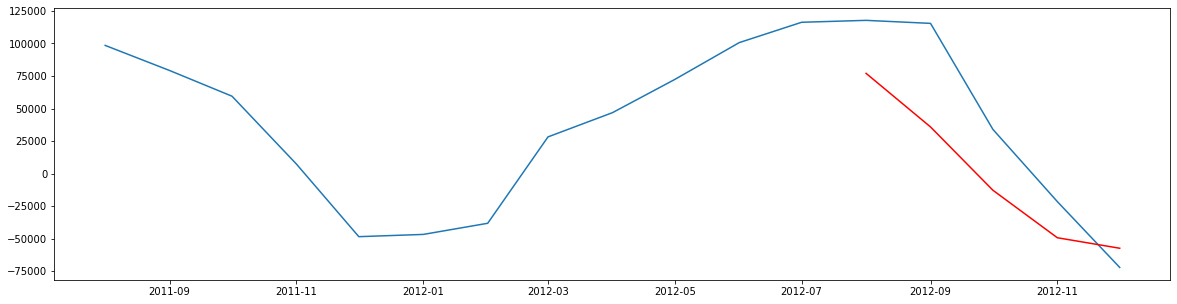

In [66]:
plt.figure(figsize=(20,5))
plt.plot(dt2_test.index, dt2_test['bikes rented'])
plt.plot(dt2_test.index, dt2_test['Predictions'], color ='r')

In [67]:
train = dt2
scalar.fit(train)
train = scalar.transform(train)
n_input =5
n_features = 1
generator = TimeseriesGenerator(train, train, n_input, batch_size =6)
model.fit_generator(generator, epochs =180)

Epoch 1/180
2/2 [==============================] - 0s 140ms/step - loss: 0.0378
Epoch 2/180
2/2 [==============================] - 0s 25ms/step - loss: 0.0155
Epoch 3/180
2/2 [==============================] - 0s 51ms/step - loss: 0.0208
Epoch 4/180
2/2 [==============================] - 0s 52ms/step - loss: 0.0236
Epoch 5/180
2/2 [==============================] - 0s 51ms/step - loss: 0.0132
Epoch 6/180
2/2 [==============================] - 0s 51ms/step - loss: 0.0176
Epoch 7/180
2/2 [==============================] - 0s 49ms/step - loss: 0.0211
Epoch 8/180
2/2 [==============================] - 0s 55ms/step - loss: 0.0167
Epoch 9/180
2/2 [==============================] - 0s 48ms/step - loss: 0.0175
Epoch 10/180
2/2 [==============================] - 0s 51ms/step - loss: 0.0142
Epoch 11/180
2/2 [==============================] - 0s 52ms/step - loss: 0.0106
Epoch 12/180
2/2 [==============================] - 0s 51ms/step - loss: 0.0038
Epoch 13/180
2/2 [==============================

In [68]:
pred_list =[]
batch = train[-n_input:].reshape(1, n_input, n_features)
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis=1)

In [69]:
add_dates =[dt2.index[-1] + DateOffset(months=x) for x in range(0,6)]
future_dates = pd.DataFrame(index=add_dates[1:], columns=dt2.columns)

In [70]:
dt2_predict= pd.DataFrame(scalar.inverse_transform(pred_list), index= future_dates[-n_input:].index, columns =['Predictions'])

In [71]:
dt2_test = pd.concat([dt2, dt2_predict], axis =1)

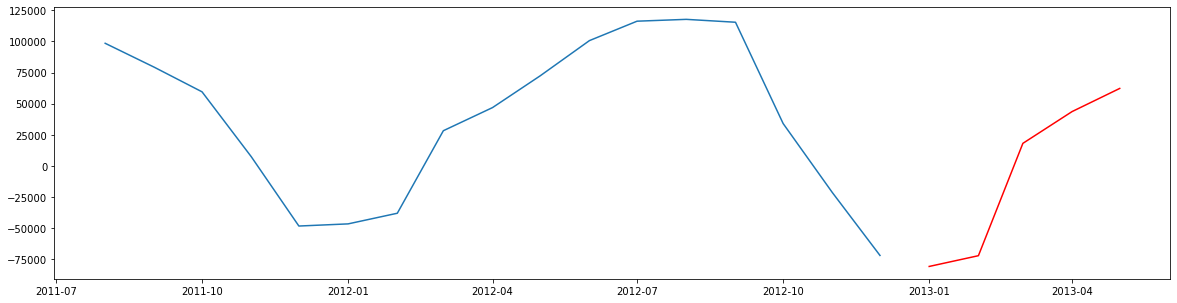

In [72]:
plt.figure(figsize=(20,5))
plt.plot(dt2_test.index, dt2_test['bikes rented'])
plt.plot(dt2_test.index, dt2_test['Predictions'], color ='r')